In [1]:
import csv,os
import pandas as pd
import spacy,re,os,numpy as np
from spacy.lang.en.stop_words import STOP_WORDS
import matplotlib.pyplot as plt
from  string  import  punctuation     

import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
import numpy as np
from sklearn import metrics 
from sklearn.pipeline import Pipeline
from sklearn import tree

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)
print('----------------The shape of records with class labels----------------')
root = '../data/clean_data/'
df = pd.read_csv(os.path.join(root,'clean_data_annotated.csv'))
#df['Sentiment'] = df['Sentiment'].apply(lambda x: 'neg' if x<0 else 'pos' if x>0 else "neutral")
df.head(10)

----------------The shape of records with class labels----------------


,UserName,Handle,Timestamp,Content,Likes,Retweets,Emojis,Comments,Tag,sentiment_scores,Textblob_sentiment_scores,Vader_sentiment_scores,Sentiment,Textblob_sentiment,Vader_sentiment
0,Michael Lewis & Friends,@Michael65413248,"""2020-07-31 11:45""",Bloggers commented on #COVID19SG #COVID19Singa...,79.0,41.0,0,0.0,GE2020SG,0.318450,-1.850372e-17,0.6369,pos,neg,pos
1,harish on wafto,@harishpillay,"""2020-07-30 07:37""",They feel that they can just keep the narrativ...,0.0,1.0,0,0.0,GE2020SG,-0.477729,-1.428571e-01,-0.8126,neg,neg,neg
2,Angry Merlion,@jj09102010,"""2020-07-25 04:25""",The legend of #singapore opposition movement. ...,0.0,0.0,0,0.0,GE2020SG,0.000000,0.000000e+00,0.0000,neutral,neutral,neutral
3,SUTD Singapore,@sutdsg,"""2020-07-22 08:30""","Regardless of race, language, or religion - th...",0.0,1.0,0,0.0,GE2020SG,-0.116667,-2.333333e-01,0.0000,neg,neg,neutral
4,Karen M. Fu,@karen_fu,"""2020-07-20 08:49""",Senior Minister Tharman Shanmugaratnam comment...,0.0,0.0,0,0.0,GE2020SG,0.290900,2.000000e-01,0.3818,pos,pos,pos
5,Pantheon Percussion,@PantheonPercuss,"""2020-07-19 10:17""",#Repost wokfunk with make_repost\r\n・・・\r\nJam...,0.0,0.0,0,0.0,GE2020SG,0.000000,0.000000e+00,0.0000,neutral,neutral,neutral
6,Karen M. Fu,@karen_fu,"""2020-07-19 11:32""",#COVID19 #coronavirus #singapore #ge2020sg\r\n...,0.0,0.0,0,0.0,GE2020SG,-0.136600,0.000000e+00,-0.2732,neg,neutral,neg
7,xxx65,@WahLau13,"""2020-07-19 09:52""",@PAPSingapore\r\n +5th - CECA!!!!! \r\n @stom...,0.0,0.0,0,0.0,GE2020SG,0.000000,0.000000e+00,0.0000,neutral,neutral,neutral
8,Aj Morris,@ajishhhh,"""2020-07-17 07:34""",I wonder if this will kena the first POFMA pos...,0.0,0.0,0,0.0,GE2020SG,0.000000,0.000000e+00,0.0000,neutral,neutral,neutral
9,Credendo,@CredendoEN,"""2020-07-16 10:10""","Strong economic fundamentals, ample government...",0.0,1.0,0,0.0,GE2020SG,0.402239,2.777778e-01,0.5267,pos,pos,pos


----------------Sample records with Length columns----------------------
                   UserName            Handle           Timestamp                                            Content  Likes Retweets Emojis  Comments                      Tag  sentiment_scores  Textblob_sentiment_scores  Vader_sentiment_scores Sentiment Textblob_sentiment Vader_sentiment  LENGTH
3063             Malay Mail        @malaymail  "2020-06-28 01:00"  Singapore 2020 General Election: Lee vs Lee | ...    2.0      0.0      0       0.0  general_election_sg2020          0.000000                   0.000000                   0.000   neutral            neutral         neutral      56
1750            IANS Tweets       @ians_india  "2020-07-01 05:50"  A total of 192 candidates turned up to compete...    0.0      0.0      0       0.0      general_election_sg          0.000000                   0.000000                   0.000   neutral            neutral         neutral     107
209   cool honey cool honey    @fogg

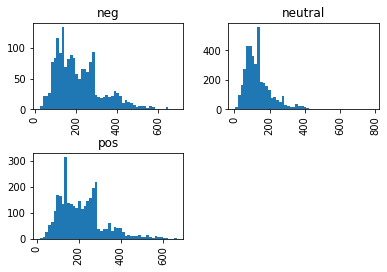

In [2]:
length=df['Content'].apply(len)
df=df.assign(LENGTH=length)
print('----------------Sample records with Length columns----------------------')
print(df.sample(frac=0.50,random_state=9).head())        
df.hist(column='LENGTH',by='Sentiment',bins=50)
plt.show()       
WNlemma = nltk.WordNetLemmatizer()

### Target distributions

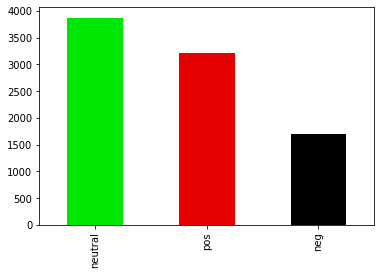

In [3]:
df['Sentiment'].value_counts().plot(kind='bar' , color= [(0, .9, 0), (.9, 0, 0), (0, 0, 0)] )

### Text Pre-processing

In [4]:
def simple_preprocess(text):
    text = text.split(',')[0].lower()
    text = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{1,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", text)
    text = re.sub(r'''(?i)\b((?:http?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{1,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", text)
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    return text
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    return TAG_RE.sub('', text)
def pre_process_nltk(text):
    tokens = nltk.word_tokenize(text)
    tokens=[WNlemma.lemmatize(t) for t in tokens]
    tokens=[word for word in tokens if word not in newstopwords]
    text_after_process=" ".join(tokens)
    return(text_after_process)
nlp = spacy.load('en_core_web_sm', vectors='en_google')
def pre_process_spacy(text, remove_stopwords=True, stem_words=False, punctuations=punctuation):
    # use spacy to do nlp process without parser and NER
    doc = nlp(text, disable=['parser', 'ner'])
    tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
    tokens = [tok for tok in tokens if tok not in newstopwords and tok not in punctuations]
    tokens = [t for t in tokens if len(t) >=3]
    text = ' '.join(tokens)
    # Clean the text
    #text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", text)
    text = re.sub(r'''(?i)\b((?:http?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", text)
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    text=" ".join(text.split())
    return(text)
custom_stopwords = [word for word in  open(os.path.join('util','custom_stopwords1.txt'), "r").read().split() if word not in list(STOP_WORDS)]
newstopwords = list(STOP_WORDS) + custom_stopwords
df['Tag'] = df['Tag'].apply(simple_preprocess) 
keys = df.Tag.value_counts().keys()
newstopwords = newstopwords + keys.tolist()
print('Stopwords count - default : {}, custom : {}, total :{}'.format(len(STOP_WORDS),len(custom_stopwords),len(newstopwords)))


Stopwords count - default : 326, custom : 17, total :357


In [5]:
labels = df['Sentiment'].unique()
i = 0
idx2class = {} 
class2idx = {}
for tp in labels:
    idx2class[i] = tp
    class2idx[tp] = i
    i += 1
idx2class

{0: 'pos', 1: 'neg', 2: 'neutral'}

In [6]:
class2idx

{'pos': 0, 'neg': 1, 'neutral': 2}

In [7]:
df['Sentiment'] = df['Sentiment'].replace(class2idx)
df['Sentiment'].value_counts()# {0: 'pos', 1: 'neg', 2: 'neutral'}

2    3868
0    3212
1    1690
Name: Sentiment, dtype: int64

In [8]:
content_text = df['Content'].apply(pre_process_spacy)
length=content_text.apply(len)
df=df.assign(LENGTH=length)
print('--------Sample records with Length columns after pre-processing----------')
#print(df.sample(frac=0.50,random_state=9).head())
X_train, X_test, y_train, y_test = train_test_split(content_text, df['Sentiment'], test_size=0.30, random_state=12)

--------Sample records with Length columns after pre-processing----------


In [9]:
import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import time,numpy as np

# Model Building - Trials & Errors

## Experiment I  : Set the vocab size to 2000

In [10]:
# instantiate the vectorizer. We set the vocab size is 2000
num_features = 2000

print("******************* Default One vs One ******************* ")
vect = CountVectorizer(max_features=num_features)
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)
# Logistic Regression
start_time = time.time()
def_ovo_LGR = LogisticRegression(multi_class='multinomial')
def_ovo_LGR.fit(X_train_dtm,y_train)
print("Total training time ",time.time()-start_time , " seconds")
def_ovo_LGR_predicted = def_ovo_LGR.predict(X_test_dtm)
print("***prediction using logistic regression***")
print(metrics.confusion_matrix(y_test,def_ovo_LGR_predicted))
print('Accuracy {}'.format(np.mean(def_ovo_LGR_predicted ==y_test)))
# Support Vector Machine
def_ovo_svm = SVC(decision_function_shape='ovo')
start_time = time.time()
def_ovo_svm.fit(X_train_dtm,y_train)
print("Total training time ",time.time()-start_time , " seconds")
def_ovo_svm_predicted = def_ovo_svm.predict(X_test_dtm)
print("***prediction using SVM ***")
print(metrics.confusion_matrix(y_test,def_ovo_svm_predicted))
print('Accuracy {}'.format(np.mean(def_ovo_svm_predicted ==y_test)))

print("******************* Default One vs All ******************* ")
# one vs. all
def_ovr_LGR = LogisticRegression(multi_class='ovr')
vect = CountVectorizer(max_features=num_features)
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)
# Logistic Regression
start_time = time.time()
def_ovr_LGR.fit(X_train_dtm,y_train)
print("Total training time ",time.time()-start_time , " seconds")
def_ovr_LGR_predicted = def_ovr_LGR.predict(X_test_dtm)
print("***prediction using logistic regression***")
print(metrics.confusion_matrix(y_test,def_ovr_LGR_predicted))
print('Accuracy {}'.format(np.mean(def_ovr_LGR_predicted ==y_test)))
# Support Vector Machine
def_ovr_svm = SVC(decision_function_shape='ovr')
start_time = time.time()
def_ovr_svm.fit(X_train_dtm,y_train)
print("Total training time ",time.time()-start_time , " seconds")
def_ovr_svm_predicted = def_ovr_svm.predict(X_test_dtm)
print("***prediction using SVM ***")
print(metrics.confusion_matrix(y_test,def_ovr_svm_predicted))
print('Accuracy {}'.format(np.mean(def_ovr_svm_predicted ==y_test)))

print("******************* Classifier One vs Rest ******************* ")
# one vs. one
from sklearn.multiclass import OneVsRestClassifier
logreg = LogisticRegression()
svm_linear = LinearSVC()

vect = CountVectorizer(max_features=num_features)
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)
# Logistic Regression
start_time = time.time()
ovr_LGR = OneVsRestClassifier(logreg)
ovr_LGR.fit(X_train_dtm,y_train)
print("Total training time ",time.time()-start_time , " seconds")
ovr_LGR_predicted = ovr_LGR.predict(X_test_dtm)
print("***prediction using logistic regression***")
print(metrics.confusion_matrix(y_test,ovr_LGR_predicted))
print('Accuracy {}'.format(np.mean(ovr_LGR_predicted ==y_test)))
# Support Vector Machine
start_time = time.time()
ovr_SVM = OneVsRestClassifier(svm_linear)
ovr_SVM.fit(X_train_dtm,y_train)
print("Total training time ",time.time()-start_time , " seconds")
ovr_svm_predicted = ovr_SVM.predict(X_test_dtm)
print("***prediction using SVM ***")
print(metrics.confusion_matrix(y_test,ovr_svm_predicted))
print('Accuracy {}'.format(np.mean(ovr_svm_predicted ==y_test)))


print("******************* Classifier One vs One ******************* ")

# one vs. one
from sklearn.multiclass import OneVsOneClassifier
logreg = LogisticRegression()
svm_linear = LinearSVC()
vect = CountVectorizer(max_features=num_features)
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)
# Logistic Regression
start_time = time.time()
ovo_LGR = OneVsOneClassifier(logreg)
ovo_LGR.fit(X_train_dtm,y_train)
print("Total training time ",time.time()-start_time , " seconds")
ovo_LGR_predicted = ovo_LGR.predict(X_test_dtm)
print("***prediction using logistic regression***")
print(metrics.confusion_matrix(y_test,ovo_LGR_predicted))
print('Accuracy {}'.format(np.mean(ovo_LGR_predicted ==y_test)))
# Support Vector Machine
start_time = time.time()
ovo_SVM = OneVsOneClassifier(svm_linear)
ovo_SVM.fit(X_train_dtm,y_train)
print("Total training time ",time.time()-start_time , " seconds")
ovo_svm_predicted = ovo_SVM.predict(X_test_dtm)
print("***prediction using SVM ***")
print(metrics.confusion_matrix(y_test,ovo_svm_predicted))
print('Accuracy {}'.format(np.mean(ovo_svm_predicted ==y_test)))

******************* Default One vs One ******************* 


C:\Users\tyzn_arthur\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Total training time  0.20242643356323242  seconds
***prediction using logistic regression***
[[ 812   44  126]
 [  74  323  108]
 [  32   21 1091]]
Accuracy 0.8460661345496009
Total training time  2.9810593128204346  seconds
***prediction using SVM ***
[[ 781   15  186]
 [ 146  207  152]
 [  68    4 1072]]
Accuracy 0.7829722538958571
******************* Default One vs All ******************* 


C:\Users\tyzn_arthur\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\tyzn_arthur\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#

Total training time  0.20541977882385254  seconds
***prediction using logistic regression***
[[ 800   40  142]
 [  72  313  120]
 [  33   14 1097]]
Accuracy 0.8399847966552642
Total training time  2.9470977783203125  seconds
***prediction using SVM ***
[[ 781   15  186]
 [ 146  207  152]
 [  68    4 1072]]
Accuracy 0.7829722538958571
******************* Classifier One vs Rest ******************* 


C:\Users\tyzn_arthur\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\tyzn_arthur\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#

Total training time  0.20545005798339844  seconds
***prediction using logistic regression***
[[ 800   40  142]
 [  72  313  120]
 [  33   14 1097]]
Accuracy 0.8399847966552642


C:\Users\tyzn_arthur\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Total training time  0.5784220695495605  seconds
***prediction using SVM ***
[[ 818   55  109]
 [  63  358   84]
 [  34   26 1084]]
Accuracy 0.8589889775750665
******************* Classifier One vs One ******************* 
Total training time  0.13962078094482422  seconds
***prediction using logistic regression***
[[ 785   50  147]
 [  89  295  121]
 [  30   22 1092]]
Accuracy 0.8255416191562144
Total training time  0.33510255813598633  seconds
***prediction using SVM ***
[[ 818   54  110]
 [  70  342   93]
 [  34   32 1078]]
Accuracy 0.8506271379703535


C:\Users\tyzn_arthur\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


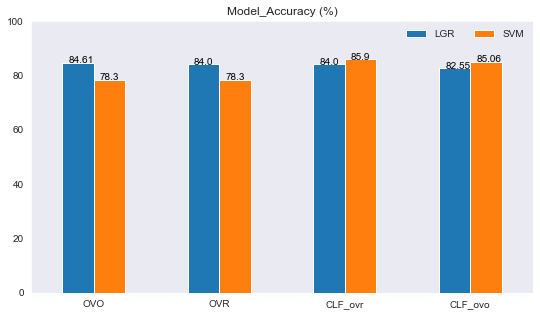

In [11]:
import seaborn as sns
sns.set_style("dark")

result_LGR = pd.Series({
    'ovo_LGR':np.round(np.mean(def_ovo_LGR_predicted ==y_test)*100,2),
    'ovr_LGR':np.round(np.mean(def_ovr_LGR_predicted ==y_test)*100,2),
    'Clf_ovr_LGR':np.round(np.mean(ovr_LGR_predicted ==y_test)*100,2),
    'Clf_ovo_LGR':np.round(np.mean(ovo_LGR_predicted ==y_test)*100,2)})
result_SVM = pd.Series({
    'ovo_svm':np.round(np.mean(def_ovo_svm_predicted ==y_test)*100,2),
    'ovr_svm':np.round(np.mean(def_ovr_svm_predicted ==y_test)*100,2),
    'Clf_ovr_svm':np.round(np.mean(ovr_svm_predicted ==y_test)*100,2),
    'Clf_ovo_svm':np.round(np.mean(ovo_svm_predicted ==y_test)*100,2)
})
index = ["OVO","OVR","CLF_ovr","CLF_ovo"]
dsel_df = pd.DataFrame({'LGR': result_LGR.tolist(),
                       'SVM': result_SVM.tolist()}, index=index)
ax = dsel_df.plot.bar(figsize=(9,5) ,rot=0 ,label = '' )
plt.legend().remove()
ax.set_title('Model_Accuracy (%)')
for rect in ax.patches:
    x = rect.get_x() +0.05
    y = rect.get_y() + rect.get_height() 
    ax.text(x, y, "{:,}".format(rect.get_height()), color='black' ,rotation=0 )
#ax.axhline(88, color='red', ls='dotted' , label = '%') 
ax.legend(loc='upper right', frameon=False,ncol = 2)
ax.set_ylim((0, 100))
plt.show()

In [12]:
# Choose SVM with One vs Rest classifier - with the highest accuray from above experiment
def_ovo_LGR_predicted = def_ovo_LGR.predict(X_test_dtm)
print('Accuracy {}'.format(np.mean(def_ovo_LGR_predicted ==y_test)))
ovr_svm_predicted = ovr_SVM.predict(X_test_dtm)
print('Accuracy {}'.format(np.mean(ovr_svm_predicted ==y_test)))

Accuracy 0.8460661345496009
Accuracy 0.8589889775750665


In [13]:
# Create PIPELINE using Best Model from above experiments       
    
lgr_predicted_pipe = Pipeline([('VECT', CountVectorizer(max_features=num_features)),
                     ('TFIDF', TfidfTransformer()),
                      ('CLF', LogisticRegression(multi_class='multinomial'))
                    ])
lgr_predicted_pipe.fit(X_train, y_train) 
predicted1 = lgr_predicted_pipe.predict(X_test)
print('Accuracy {}'.format(np.mean(predicted1 ==y_test)))


l_svm_predicted_pipe = Pipeline([('VECT', CountVectorizer(max_features=num_features)),
                     ('TFIDF', TfidfTransformer()),
                      ('CLF', OneVsRestClassifier(svm_linear))
                    ])
l_svm_predicted_pipe.fit(X_train, y_train) 
predicted2 = l_svm_predicted_pipe.predict(X_test)
print('Accuracy {}'.format(np.mean(predicted2 ==y_test)))

Accuracy 0.8004561003420753
Accuracy 0.85480805777271


C:\Users\tyzn_arthur\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


#### Findings
- Adding TFIDF in the training pipeline decreases the accuracy of the model,
Will not to involved TFIDF in training pipeline

In [14]:
# XGBoost Classifier
xgb_clf = xgb.XGBClassifier(max_depth=10, n_estimators=280, objective="multi:softmax", random_state=1)
start_time = time.time()
xgb_clf.fit(X_train_dtm,y_train)
print("Total training time ",time.time()-start_time , " seconds")
xgb_predicted = xgb_clf.predict(X_test_dtm)
print("***prediction using XGBoost regression***")
print(metrics.confusion_matrix(y_test,xgb_predicted))
print('Accuracy {}'.format(np.mean(xgb_predicted ==y_test)))
# Naive Bayes
naive_bayes = MultinomialNB()
start_time = time.time()
naive_bayes.fit(X_train_dtm,y_train)
print("Total training time ",time.time()-start_time , " seconds")
nb_predictions = naive_bayes.predict(X_test_dtm)
print("***prediction using Naive Bays regression***")
print(metrics.confusion_matrix(y_test,nb_predictions))
print('Accuracy {}'.format(np.mean(nb_predictions ==y_test)))
# RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=1000, random_state=1)
start_time = time.time()
rf_clf.fit(X_train_dtm,y_train)
print("Total training time ",time.time()-start_time , " seconds")
rf_predictions = rf_clf.predict(X_test_dtm)
print("***prediction using random forest regression***")
print(metrics.confusion_matrix(y_test,rf_predictions))
print('Accuracy {}'.format(np.mean(rf_predictions ==y_test)))

# Combine ALL - Ensemble Voting Classifier
#estimators=[('lgr', logreg1), ('svm', ovr_SVM), ('xgb', xgb_clf),('nb',naive_bayes),('rf',rf_clf)]
estimators=[('lgr', def_ovo_LGR), ('svm', ovr_SVM), ('xgb', xgb_clf),('rf',rf_clf)] # Excluding Naive Bayes achieves better accuracy
clf = VotingClassifier(estimators, voting='hard')
start_time = time.time()
clf.fit(X_train_dtm,y_train)
print("Total training time ",time.time()-start_time , " seconds")
em_prediction = clf.predict(X_test_dtm)
print("***prediction using Ensemble***")
print('Accuracy {}'.format(np.mean(em_prediction ==y_test)))

Total training time  1.9716951847076416  seconds
***prediction using XGBoost regression***
[[ 834   50   98]
 [  57  343  105]
 [  23   13 1108]]
Accuracy 0.8684910680349677
Total training time  0.002991914749145508  seconds
***prediction using Naive Bays regression***
[[733  99 150]
 [100 324  81]
 [134  57 953]]
Accuracy 0.7639680729760547
Total training time  20.398470640182495  seconds
***prediction using random forest regression***
[[ 808   21  153]
 [  88  297  120]
 [  44    6 1094]]
Accuracy 0.8358038768529077


C:\Users\tyzn_arthur\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\tyzn_arthur\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Total training time  23.260766983032227  seconds
***prediction using Ensemble***
Accuracy 0.8692512352717597


No handles with labels found to put in legend.


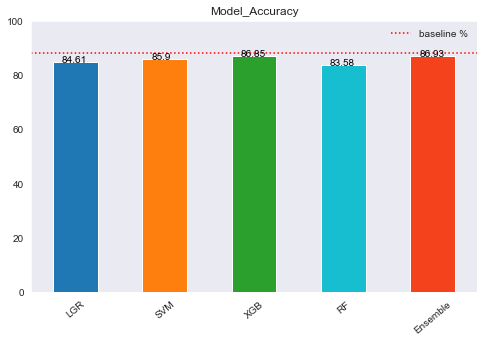

In [15]:
result = pd.Series({
    'LGR':np.round(np.mean(def_ovo_LGR_predicted ==y_test)*100,2),
    'SVM':np.round(np.mean(ovr_svm_predicted ==y_test)*100,2),
    'XGB':np.round(np.mean(xgb_predicted ==y_test)*100,2),
    'RF':np.round(np.mean(rf_predictions ==y_test)*100,2),
    'Ensemble':np.round(np.mean(em_prediction ==y_test)*100,2),
})
fig, ax = plt.subplots(figsize=(8, 5))
result.plot.bar(rot=40, ax=ax, label='' , color  = ['#1f77b4', '#ff7f0e', '#2ca02c', '#17becf', '#F3421C'])
plt.legend().remove()
ax.set_title('Model_Accuracy')
for rect in ax.patches:
    x = rect.get_x() + 0.1 
    y = rect.get_y() + rect.get_height() 
    ax.text(x, y, "{:,}".format(rect.get_height()), color='black')
ax.axhline(88, color='red', ls='dotted' , label = 'baseline %') 
ax.legend(loc='upper right', frameon=False,ncol = 2)
ax.set_ylim((0, 100))
plt.show()

## Experiment II  : Set the vocab size to 5000

In [16]:
num_features = 5000

In [17]:
print("******************* Default One vs One ******************* ")
vect = CountVectorizer(max_features=num_features)
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)
# Logistic Regression
start_time = time.time()
def_ovo_LGR = LogisticRegression(multi_class='multinomial')
def_ovo_LGR.fit(X_train_dtm,y_train)
print("Total training time ",time.time()-start_time , " seconds")
def_ovo_LGR_predicted = def_ovo_LGR.predict(X_test_dtm)
print("***prediction using logistic regression***")
print(metrics.confusion_matrix(y_test,def_ovo_LGR_predicted))
print('Accuracy {}'.format(np.mean(def_ovo_LGR_predicted ==y_test)))
# Support Vector Machine
def_ovo_svm = SVC(decision_function_shape='ovo')
start_time = time.time()
def_ovo_svm.fit(X_train_dtm,y_train)
print("Total training time ",time.time()-start_time , " seconds")
def_ovo_svm_predicted = def_ovo_svm.predict(X_test_dtm)
print("***prediction using SVM ***")
print(metrics.confusion_matrix(y_test,def_ovo_svm_predicted))
print('Accuracy {}'.format(np.mean(def_ovo_svm_predicted ==y_test)))

print("******************* Default One vs All ******************* ")
# one vs. all
def_ovr_LGR = LogisticRegression(multi_class='ovr')
vect = CountVectorizer(max_features=num_features)
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)
# Logistic Regression
start_time = time.time()
def_ovr_LGR.fit(X_train_dtm,y_train)
print("Total training time ",time.time()-start_time , " seconds")
def_ovr_LGR_predicted = def_ovr_LGR.predict(X_test_dtm)
print("***prediction using logistic regression***")
print(metrics.confusion_matrix(y_test,def_ovr_LGR_predicted))
print('Accuracy {}'.format(np.mean(def_ovr_LGR_predicted ==y_test)))
# Support Vector Machine
def_ovr_svm = SVC(decision_function_shape='ovr')
start_time = time.time()
def_ovr_svm.fit(X_train_dtm,y_train)
print("Total training time ",time.time()-start_time , " seconds")
def_ovr_svm_predicted = def_ovr_svm.predict(X_test_dtm)
print("***prediction using SVM ***")
print(metrics.confusion_matrix(y_test,def_ovr_svm_predicted))
print('Accuracy {}'.format(np.mean(def_ovr_svm_predicted ==y_test)))

print("******************* Classifier One vs Rest ******************* ")
# one vs. one
from sklearn.multiclass import OneVsRestClassifier
logreg = LogisticRegression()
svm_linear = LinearSVC()
vect = CountVectorizer(max_features=num_features)
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)
# Logistic Regression
start_time = time.time()
ovr_LGR = OneVsRestClassifier(logreg)
ovr_LGR.fit(X_train_dtm,y_train)
print("Total training time ",time.time()-start_time , " seconds")
ovr_LGR_predicted = ovr_LGR.predict(X_test_dtm)
print("***prediction using logistic regression***")
print(metrics.confusion_matrix(y_test,ovr_LGR_predicted))
print('Accuracy {}'.format(np.mean(ovr_LGR_predicted ==y_test)))
# Support Vector Machine
start_time = time.time()
ovr_SVM = OneVsRestClassifier(svm_linear)
ovr_SVM.fit(X_train_dtm,y_train)
print("Total training time ",time.time()-start_time , " seconds")
ovr_svm_predicted = ovr_SVM.predict(X_test_dtm)
print("***prediction using SVM ***")
print(metrics.confusion_matrix(y_test,ovr_svm_predicted))
print('Accuracy {}'.format(np.mean(ovr_svm_predicted ==y_test)))


print("******************* Classifier One vs One ******************* ")

# one vs. one
from sklearn.multiclass import OneVsOneClassifier
logreg = LogisticRegression()
svm_linear = LinearSVC()
vect = CountVectorizer(max_features=num_features)
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)
# Logistic Regression
start_time = time.time()
ovo_LGR = OneVsOneClassifier(logreg)
ovo_LGR.fit(X_train_dtm,y_train)
print("Total training time ",time.time()-start_time , " seconds")
ovo_LGR_predicted = ovo_LGR.predict(X_test_dtm)
print("***prediction using logistic regression***")
print(metrics.confusion_matrix(y_test,ovo_LGR_predicted))
print('Accuracy {}'.format(np.mean(ovo_LGR_predicted ==y_test)))
# Support Vector Machine
start_time = time.time()
ovo_SVM = OneVsOneClassifier(svm_linear)
ovo_SVM.fit(X_train_dtm,y_train)
print("Total training time ",time.time()-start_time , " seconds")
ovo_svm_predicted = ovo_SVM.predict(X_test_dtm)
print("***prediction using SVM ***")
print(metrics.confusion_matrix(y_test,ovo_svm_predicted))
print('Accuracy {}'.format(np.mean(ovo_svm_predicted ==y_test)))
# XGBoost Classifier
xgb_clf = xgb.XGBClassifier(max_depth=10, n_estimators=280, objective="multi:softmax", random_state=1)
start_time = time.time()
xgb_clf.fit(X_train_dtm,y_train)
print("Total training time ",time.time()-start_time , " seconds")
xgb_predicted = xgb_clf.predict(X_test_dtm)
print("***prediction using XGBoost regression***")
print(metrics.confusion_matrix(y_test,xgb_predicted))
print('Accuracy {}'.format(np.mean(xgb_predicted ==y_test)))
# Naive Bayes
naive_bayes = MultinomialNB()
start_time = time.time()
naive_bayes.fit(X_train_dtm,y_train)
print("Total training time ",time.time()-start_time , " seconds")
nb_predictions = naive_bayes.predict(X_test_dtm)
print("***prediction using Naive Bays regression***")
print(metrics.confusion_matrix(y_test,nb_predictions))
print('Accuracy {}'.format(np.mean(nb_predictions ==y_test)))
# RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=1000, random_state=1)
start_time = time.time()
rf_clf.fit(X_train_dtm,y_train)
print("Total training time ",time.time()-start_time , " seconds")
rf_predictions = rf_clf.predict(X_test_dtm)
print("***prediction using random forest regression***")
print(metrics.confusion_matrix(y_test,rf_predictions))
print('Accuracy {}'.format(np.mean(rf_predictions ==y_test)))

# Combine ALL - Ensemble Voting Classifier
#estimators=[('lgr', logreg1), ('svm', ovr_SVM), ('xgb', xgb_clf),('nb',naive_bayes),('rf',rf_clf)]
estimators=[ ('svm', ovr_SVM), ('xgb', xgb_clf)] # Excluding Naive Bayes achieves better accuracy
clf = VotingClassifier(estimators, voting='hard')
start_time = time.time()
clf.fit(X_train_dtm,y_train)
print("Total training time ",time.time()-start_time , " seconds")
em_prediction = clf.predict(X_test_dtm)
print("***prediction using Ensemble***")
print('Accuracy {}'.format(np.mean(em_prediction ==y_test)))

******************* Default One vs One ******************* 


C:\Users\tyzn_arthur\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Total training time  0.5006289482116699  seconds
***prediction using logistic regression***
[[ 824   40  118]
 [  59  361   85]
 [  28   16 1100]]
Accuracy 0.8684910680349677
Total training time  3.2802605628967285  seconds
***prediction using SVM ***
[[ 786    8  188]
 [ 153  208  144]
 [  68    1 1075]]
Accuracy 0.7863930064614215
******************* Default One vs All ******************* 


C:\Users\tyzn_arthur\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Total training time  0.653249979019165  seconds
***prediction using logistic regression***
[[ 806   37  139]
 [  61  338  106]
 [  29   11 1104]]
Accuracy 0.8544279741543139
Total training time  3.2792584896087646  seconds
***prediction using SVM ***
[[ 786    8  188]
 [ 153  208  144]
 [  68    1 1075]]
Accuracy 0.7863930064614215
******************* Classifier One vs Rest ******************* 


C:\Users\tyzn_arthur\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Total training time  0.6552443504333496  seconds
***prediction using logistic regression***
[[ 806   37  139]
 [  61  338  106]
 [  29   11 1104]]
Accuracy 0.8544279741543139


C:\Users\tyzn_arthur\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Total training time  0.6502590179443359  seconds
***prediction using SVM ***
[[ 845   38   99]
 [  49  386   70]
 [  24   15 1105]]
Accuracy 0.8878753325731661
******************* Classifier One vs One ******************* 
Total training time  0.4497945308685303  seconds
***prediction using logistic regression***
[[ 800   41  141]
 [  69  325  111]
 [  28   18 1098]]
Accuracy 0.8449258836944128
Total training time  0.4298522472381592  seconds
***prediction using SVM ***
[[ 836   47   99]
 [  56  377   72]
 [  22   17 1105]]
Accuracy 0.8810338274420373
Total training time  2.5341904163360596  seconds
***prediction using XGBoost regression***
[[ 836   47   99]
 [  61  348   96]
 [  21   15 1108]]
Accuracy 0.87115165336374
Total training time  0.004987478256225586  seconds
***prediction using Naive Bays regression***
[[775  84 123]
 [ 99 330  76]
 [128  42 974]]
Accuracy 0.790193842645382
Total training time  24.70301580429077  seconds
***prediction using random forest regression***
[[ 79

C:\Users\tyzn_arthur\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Total training time  3.123643636703491  seconds
***prediction using Ensemble***
Accuracy 0.8912960851387305


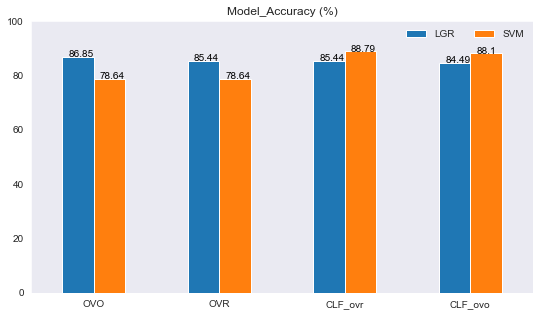

In [18]:
result_LGR = pd.Series({
    'ovo_LGR':np.round(np.mean(def_ovo_LGR_predicted ==y_test)*100,2),
    'ovr_LGR':np.round(np.mean(def_ovr_LGR_predicted ==y_test)*100,2),
    'Clf_ovr_LGR':np.round(np.mean(ovr_LGR_predicted ==y_test)*100,2),
    'Clf_ovo_LGR':np.round(np.mean(ovo_LGR_predicted ==y_test)*100,2)})
result_SVM = pd.Series({
    'ovo_svm':np.round(np.mean(def_ovo_svm_predicted ==y_test)*100,2),
    'ovr_svm':np.round(np.mean(def_ovr_svm_predicted ==y_test)*100,2),
    'Clf_ovr_svm':np.round(np.mean(ovr_svm_predicted ==y_test)*100,2),
    'Clf_ovo_svm':np.round(np.mean(ovo_svm_predicted ==y_test)*100,2)
})
index = ["OVO","OVR","CLF_ovr","CLF_ovo"]
dsel_df = pd.DataFrame({'LGR': result_LGR.tolist(),
                       'SVM': result_SVM.tolist()}, index=index)
ax = dsel_df.plot.bar(figsize=(9,5) ,rot=0 ,label = '' )
plt.legend().remove()
ax.set_title('Model_Accuracy (%)')
for rect in ax.patches:
    x = rect.get_x() +0.05
    y = rect.get_y() + rect.get_height() 
    ax.text(x, y, "{:,}".format(rect.get_height()), color='black' ,rotation=0 )
#ax.axhline(88, color='red', ls='dotted' , label = '%') 
ax.legend(loc='upper right', frameon=False,ncol = 2)
ax.set_ylim((0, 100))
plt.show()

No handles with labels found to put in legend.


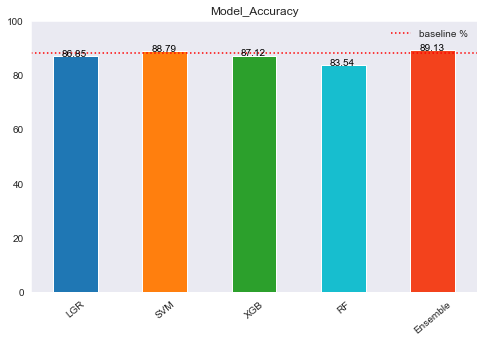

In [19]:
import seaborn as sns
sns.set_style("dark")

result = pd.Series({
    'LGR':np.round(np.mean(def_ovo_LGR_predicted ==y_test)*100,2),
    'SVM':np.round(np.mean(ovr_svm_predicted ==y_test)*100,2),
    'XGB':np.round(np.mean(xgb_predicted ==y_test)*100,2),
    'RF':np.round(np.mean(rf_predictions ==y_test)*100,2),
    'Ensemble':np.round(np.mean(em_prediction ==y_test)*100,2),
})
fig, ax = plt.subplots(figsize=(8, 5))
result.plot.bar(rot=40, ax=ax, label='' , color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#17becf', '#F3421C'])
plt.legend().remove()
ax.set_title('Model_Accuracy')
for rect in ax.patches:
    x = rect.get_x() + 0.1 
    y = rect.get_y() + rect.get_height() 
    ax.text(x, y, "{:,}".format(rect.get_height()), color='black')
ax.axhline(88, color='red', ls='dotted' , label = 'baseline %') 
ax.legend(loc='upper right', frameon=False,ncol = 2)
ax.set_ylim((0, 100))
plt.show()

### Machine Learning - Findings

* From experiment I  (vocab size of 2k) , voting classifiers achieves the highest accuracy - 86.93%
* From experiment II  (vocab size of 5k) , still voting classifiers achieves the highest accuracy - 89.13%

# Classification using deeplearning -- Keras

In [20]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Conv1D,LSTM, Bidirectional
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D,SpatialDropout1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from numpy import array,asarray,zeros

In [21]:
 pd.get_dummies(df['Sentiment']).values

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       ...,
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0]], dtype=uint8)

In [22]:
#Prepare the dataset
X = []
sentences = list(df['Content'])
for sen in sentences:
    X.append(pre_process_spacy(sen)) 
y = pd.get_dummies(df['Sentiment']).values#Converting categorical labels to numbers
#y = df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1 
maxlen = 40 # Max number of words in each tweets.
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen) #Truncate and pad the input sequences
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [23]:
sentences[0]

'Bloggers commented on #COVID19SG #COVID19Singapore & #Singapore #GE2020SG #GE2020 went missing before/after 10 July 2020 http://emmanuel-maria.biz/index_files/Page2494.htm…\r\nThe #Singaporeans are actively searching for them! Please pray for their safety & we hope to find them quickly. Please RT. Many Thanks.'

In [24]:
simple_preprocess(sentences[0])

'bloggers commented on  covid19sg  covid19singapore    singapore  ge2020sg  ge2020 went missing before after 10 july 2020    the  singaporeans are actively searching for them !  please pray for their safety   we hope to find them quickly  please rt  many thanks '

In [25]:
tokenizer.word_index

{'singapore': 1,
 'election': 2,
 'general': 3,
 'party': 4,
 'pap': 5,
 '2020': 6,
 'vote': 7,
 'singaporeelection': 8,
 'sgvote': 9,
 'com': 10,
 'win': 11,
 'singaporevote': 12,
 'result': 13,
 'news': 14,
 'opposition': 15,
 'grc': 16,
 'lee': 17,
 'day': 18,
 'people': 19,
 'straitstimes': 20,
 'rule': 21,
 'noblankcheque': 22,
 'july': 23,
 'time': 24,
 'minister': 25,
 'seat': 26,
 'candidate': 27,
 'singaporeans': 28,
 'parliament': 29,
 'poll': 30,
 'hold': 31,
 'new': 32,
 'count': 33,
 'politics': 34,
 'prime': 35,
 'coast': 36,
 'good': 37,
 'hsien': 38,
 'political': 39,
 'polling': 40,
 'covid': 41,
 'like': 42,
 'read': 43,
 'sengkang': 44,
 's': 45,
 'contest': 46,
 'pandemic': 47,
 'sample': 48,
 'live': 49,
 'voter': 50,
 'action': 51,
 'loong': 52,
 'year': 53,
 'singaporevotessingapore': 54,
 'come': 55,
 'today': 56,
 'need': 57,
 '19': 58,
 'east': 59,
 'country': 60,
 'workers': 61,
 'psp': 62,
 'tan': 63,
 'watch': 64,
 'social': 65,
 'smc': 66,
 '2': 67,
 'look

### Experiment III - Model Building 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 100)           835600    
_________________________________________________________________
flatten (Flatten)            (None, 4000)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 12003     
Total params: 847,603
Trainable params: 847,603
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
77/77 [==============================] - 1s 8ms/step - loss: 0.9414 - acc: 0.5704 - val_loss: 0.9019 - val_acc: 0.5904
Epoch 2/100
77/77 [==============================] - 0s 6ms/step - loss: 0.7655 - acc: 0.6656 - val_loss: 0.7578 - val_acc: 0.6726
Epoch 3/100
77/77 [==============================] - 0s 6ms/step - loss: 0.5840 - acc: 0.7925 - val_loss: 0.6606 

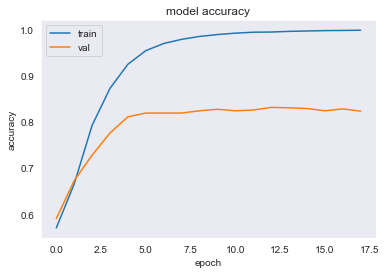

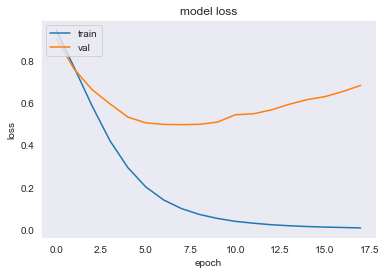

In [26]:
exp3_result = []
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, input_length=maxlen ) #map vocab indices into a space of dimensionality
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(3,  activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])#rmsprop
print(model.summary())
history = model.fit(X_train, y_train, epochs=100, batch_size=64,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=10, min_delta=0.001)])
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Accuracy:", score[1])
exp3_result.append(np.round(score[1]*100,1))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 100)           835600    
_________________________________________________________________
conv1d (Conv1D)              (None, 36, 128)           64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 900,115
Trainable params: 900,115
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
77/77 [==============================] - 1s 8ms/step - loss: 1.0282 - acc: 0.4726 - val_loss: 0.9

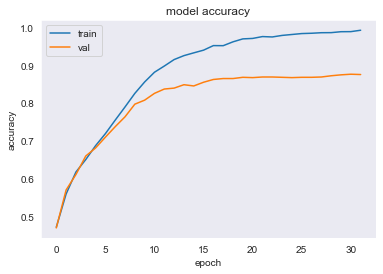

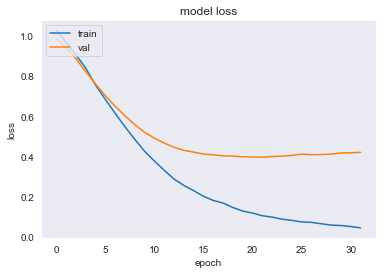

In [27]:
cnn_model = Sequential()
embedding_layer = Embedding(vocab_size, 100, input_length=maxlen)
cnn_model.add(embedding_layer)
cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(3,  activation='softmax'))
cnn_model.compile(optimizer='Adamax', loss='categorical_crossentropy', metrics=['acc'])#rmsprop
print(cnn_model.summary())
history = cnn_model.fit(X_train, y_train, epochs=200, batch_size=64,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=10, min_delta=0.001)])
score = cnn_model.evaluate(X_test, y_test, verbose=1)
exp3_result.append(np.round(score[1]*100,1))
print("Test Accuracy:", score[1])

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc = 'upper left')
plt.show()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 40, 100)           835600    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 40, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
Total params: 953,235
Trainable params: 953,235
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
77/77 [==============================] - 1s 13ms/step - loss: 0.9413 - acc: 0.5587 - val_loss: 0.7675 - val_acc: 0.6849
Epoch 2/100
77/77 [==============================] - 1s 10ms/step - loss: 0.6976 - acc: 0.7054 - val_loss: 0.

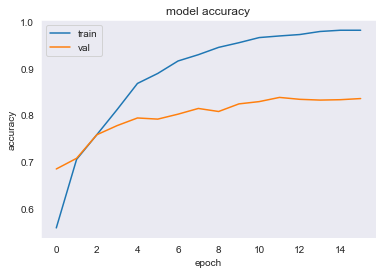

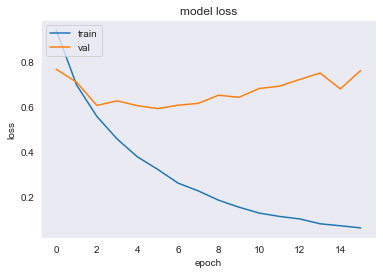

In [28]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, input_length=maxlen)
model.add(embedding_layer)
model.add(SpatialDropout1D(0.1))
model.add(LSTM(128))
model.add(Dense(3,  activation='softmax'))
#rmsprop,adam
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])#Adamax
print(model.summary())
history = model.fit(X_train, y_train, epochs=100, batch_size=64,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0001)])
score = model.evaluate(X_test, y_test, verbose=1)
exp3_result.append(np.round(score[1]*100,1))
print("Test Accuracy:", score[1])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

### Experiment IV - Model Training  -  Pre-trained word vectors
- GloVe: Global Vectors for Word Representation
- Download the pre-trained wordvectors from #https://github.com/stanfordnlp/GloVe

In [29]:
embeddings_dictionary = dict()
glove_file = open('util/glove.twitter.27B.100d.txt', encoding="utf8") 

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100)) # fixed emb dim 
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [30]:
embedding_matrix.shape

(8356, 100)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 40, 100)           835600    
_________________________________________________________________
flatten_1 (Flatten)          (None, 4000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 12003     
Total params: 847,603
Trainable params: 12,003
Non-trainable params: 835,600
_________________________________________________________________
None
Epoch 1/100
77/77 [==============================] - 0s 3ms/step - loss: 0.9626 - acc: 0.5571 - val_loss: 0.9147 - val_acc: 0.6010
Epoch 2/100
77/77 [==============================] - 0s 2ms/step - loss: 0.8221 - acc: 0.6555 - val_loss: 0.8719 - val_acc: 0.6246
Epoch 3/100
77/77 [==============================] - 0s 2ms/step - loss: 0.7570 - acc: 0.6990 - val_loss: 

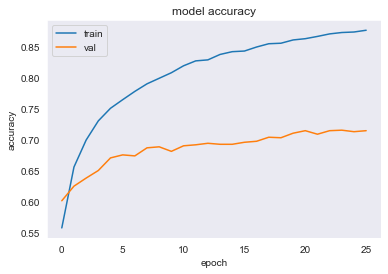

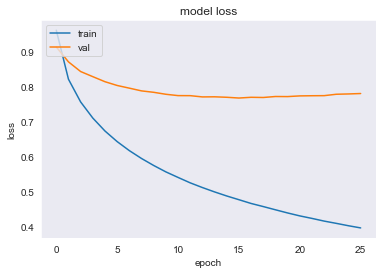

In [31]:
exp4_result = []
model = Sequential()
#The first layer is the embedded layer that uses 100 length vectors to represent each word.
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False) 
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(3,  activation='softmax'))
model.compile(optimizer='Adamax', loss='categorical_crossentropy', metrics=['acc'])#rmsprop
print(model.summary())
history = model.fit(X_train, y_train, epochs=100, batch_size=64,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0001)])
score = model.evaluate(X_test, y_test, verbose=1)
exp4_result.append(np.round(score[1]*100,1))
print("Test Accuracy:", score[1])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 40, 100)           835600    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 36, 128)           64128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 387       
Total params: 900,115
Trainable params: 64,515
Non-trainable params: 835,600
_________________________________________________________________
None
Epoch 1/100
77/77 [==============================] - 0s 4ms/step - loss: 1.0627 - acc: 0.5184 - val_loss

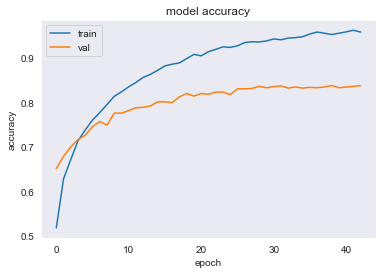

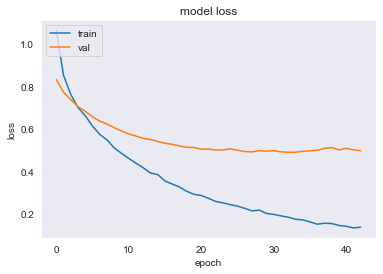

In [32]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(3,  activation='softmax'))
model.compile(optimizer='Adamax', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())
history = model.fit(X_train, y_train, epochs=100, batch_size=64,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=10, min_delta=0.001)])
score = model.evaluate(X_test, y_test, verbose=1)
exp4_result.append(np.round(score[1]*100,1))
print("Test Accuracy:", score[1])


plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc = 'upper left')
plt.show()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 40, 100)           835600    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 40, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 387       
Total params: 953,235
Trainable params: 117,635
Non-trainable params: 835,600
_________________________________________________________________
None
Epoch 1/100
87/87 [==============================] - 1s 8ms/step - loss: 0.8966 - acc: 0.5835 - val_loss: 0.8705 - val_acc: 0.6173
Epoch 2/100
87/87 [==============================] - 0s 5ms/step - loss: 0.7806 - acc: 0.6588 - val_loss

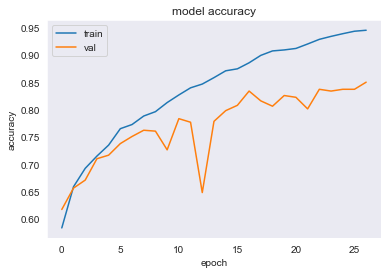

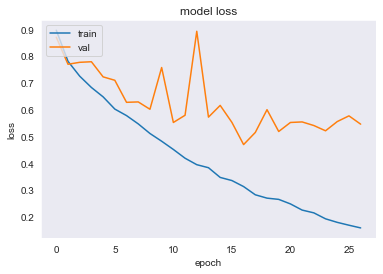

In [33]:
model_lstm = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model_lstm.add(embedding_layer)
model_lstm.add(SpatialDropout1D(0.1))
model_lstm.add(LSTM(128))
model_lstm.add(Dense(3,  activation='softmax'))
#rmsprop,adam
model_lstm.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])#Adamax
print(model_lstm.summary())
history = model_lstm.fit(X_train, y_train, epochs=100, batch_size=64,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0001)])
score = model_lstm.evaluate(X_test, y_test, verbose=1)
exp4_result.append(np.round(score[1]*100,1))
print("Test Accuracy:", score[1])

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

# Predictions and Voila

### True Predictions by both CNN & LSTM Model

In [34]:
# Positive Predictions
idx = 100 
print('Raw data ')
print(sentences[idx])
instance = X[idx]
print(' ')
print('clean data ')
print(idx ,':' + instance)
instance = tokenizer.texts_to_sequences(instance)
flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]
instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)
pred1 = cnn_model.predict(instance)
pred2 = model_lstm.predict(instance)
print(' ')
print("Prediction LSTM : " + idx2class.get(np.argmax(pred1, axis=1)[0]))
print("Prediction CNN : " + idx2class.get(np.argmax(pred2, axis=1)[0]))
#{'pos': 0, 'neg': 1, 'neutral': 2}

Raw data 
Despite his humorous intro, people should focus on the message he has after. It’s quite inspiring. #GE2020 #GE2020SG
 
clean data 
100 :despite humorous intro people focus message inspiring
 
Prediction LSTM : pos
Prediction CNN : pos


In [35]:
idx = 1111
print('Raw data ')
print(sentences[idx])
instance = X[idx]
print(' ')
print('clean data ')
print(idx ,':' + instance)
instance = tokenizer.texts_to_sequences(instance)
flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]
instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)
pred1 = cnn_model.predict(instance)
pred2 = model_lstm.predict(instance)
print(' ')
print("Prediction LSTM :  " + idx2class.get(np.argmax(pred1, axis=1)[0]))
print("Prediction CNN :  " + idx2class.get(np.argmax(pred2, axis=1)[0]))
#{'pos': 0, 'neg': 1, 'neutral': 2}

Raw data 
What the fuck, the Singapore general election is on Wikipedia? Goodness me....
 
clean data 
1111 :fuck singapore general election wikipedia goodness
 
Prediction LSTM :  neg
Prediction CNN :  neg


### False Predictions by both CNN & LSTM Model

In [36]:
idx = 4234 
print('Raw data ')
print(sentences[idx])
instance = X[idx]
print(' ')
print('clean data ')
print(idx ,':' + instance)
instance = tokenizer.texts_to_sequences(instance)
flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]
instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)
pred1 = cnn_model.predict(instance)
pred2 = model_lstm.predict(instance)
print(' ')
print("Prediction LSTM : " + idx2class.get(np.argmax(pred1, axis=1)[0]))
print("Prediction CNN : " + idx2class.get(np.argmax(pred2, axis=1)[0]))
#{'pos': 0, 'neg': 1, 'neutral': 2}

Raw data 
#GE2020 PM Lee prefers to surround himself with YES men and YES women https://facebook.com/story.php?story_fbid=10221083226924167&id=1048331169… #sgelection #sgelections #NoBlankCheque #sgvotes
 
clean data 
4234 :lee prefer surround yes man yes woman noblankcheque sgvote
 
Prediction LSTM : neg
Prediction CNN : neg


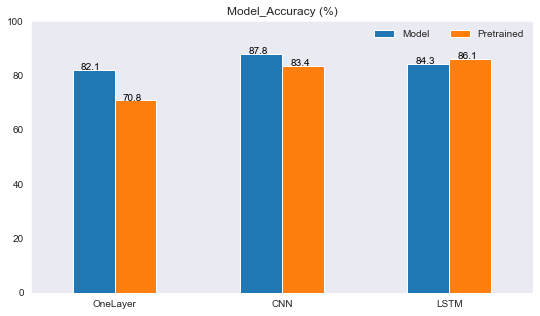

In [37]:
import seaborn as sns
sns.set_style("dark")

#exp4_result.append(score[1])

index = ["OneLayer","CNN","LSTM"]
dsel_df = pd.DataFrame({'Model': exp3_result,
                       'Pretrained': exp4_result}, index=index)
ax = dsel_df.plot.bar(figsize=(9,5) ,rot=0 ,label = '' )
plt.legend().remove()
ax.set_title('Model_Accuracy (%)')
for rect in ax.patches:
    x = rect.get_x() +0.05
    y = rect.get_y() + rect.get_height() 
    ax.text(x, y, "{:,}".format(rect.get_height()), color='black' ,rotation=0 )
#ax.axhline(88, color='red', ls='dotted' , label = '%') 
ax.legend(loc='upper right', frameon=False,ncol = 2)
ax.set_ylim((0, 100))
plt.show()

### Findings
From Experiments III and IV; 
CNN (Experiment III) outperforms LSTM + Pre-trained model (Experiment IV) ;has the best model accuracy of 87.8%